In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
plt.ion()

import scipy
from PIL import Image
from scipy import ndimage

    
    
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis


# Set random seed
np.random.seed(0)

import h5py

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
   
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))



# Look at some data
print(train_set_x_orig[0])
print(train_set_y_orig[0])

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
[[[17 31 56]
  [22 33 59]
  [25 35 62]
  ...
  [ 1 28 57]
  [ 1 26 56]
  [ 1 22 51]]

 [[25 36 62]
  [28 38 64]
  [30 40 67]
  ...
  [ 1 27 56]
  [ 1 25 55]
  [ 2 21 51]]

 [[32 40 67]
  [34 42 69]
  [35 42 70]
  ...
  [ 1 25 55]
  [ 0 24 54]
  [ 1 21 51]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0

y = [1], it's a 'cat' picture.


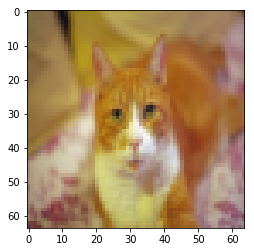

In [3]:
# Example of a picture
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

In [4]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

#standardize our dataset
#see lab 1 notes for more info
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [5]:
sess = tf.InteractiveSession()

In [6]:
## Input pixels, flattened
x = tf.placeholder("float", [12288, None])
## Known labels
y = tf.placeholder("float", [1, None])

# Variables
W = tf.Variable(tf.zeros([1, 12288]))
b = tf.Variable(tf.zeros([1]))

# Just initialize
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [44]:
# Just initialize
sess.run(tf.initialize_all_variables())

In [8]:
# Define model
z = tf.add(tf.matmul(W, x),b)
A = tf.sigmoid(z)


print ("A is: " + str(A.shape))
print ("W is: " + str(W.shape))
print ("x is: " + str(x.shape))
print ("z is: " + str(z.shape))
print ("y is: " + str(y.shape))
#print ("Y_prediction is: " + str(Y_prediction.shape))
print(b)


A is: (1, ?)
W is: (1, 12288)
x is: (12288, ?)
z is: (1, ?)
y is: (1, ?)
<tf.Variable 'Variable_1:0' shape=(1,) dtype=float32_ref>


In [9]:
# Cost function
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= z, labels= y))
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= z, labels= y)

# How we train (GradientDescent)
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)



In [10]:
# map CAT data to my TF template code
dataset = train_set_x
test_dataset = test_set_x  
y_train_vector = train_set_y_orig
y_test_vector = test_set_y_orig

print ("the shape of dataset is :" + str (dataset.shape))
print ("the shape of test_dataset is :" + str (test_dataset.shape))
print ("the shape of y_train_vector is :" + str (y_train_vector.shape))
print ("the shape of y_test_vector is :" + str (y_test_vector.shape))

the shape of dataset is :(12288, 209)
the shape of test_dataset is :(12288, 50)
the shape of y_train_vector is :(1, 209)
the shape of y_test_vector is :(1, 50)


In [11]:
# Actually train
epochs = 1000

print_cost = True
costs = []

# Actual Prediction
prediction = tf.round(tf.sigmoid(z))
predictions_correct = tf.cast(tf.equal(prediction, y), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

train_acc = []
test_acc = []


for i in tqdm(range(epochs)):
    train_step.run(feed_dict={x: dataset, y: y_train_vector})
    
    temp_cost = sess.run(cross_entropy, feed_dict={x: dataset, y: y_train_vector})
    costs.append(temp_cost)
    
    temp_acc_train = sess.run(accuracy, feed_dict={x: dataset, y: y_train_vector})
    train_acc.append(temp_acc_train)
    
    temp_acc_test = sess.run(accuracy, feed_dict={x: test_dataset, y: y_test_vector})
    test_acc.append(temp_acc_test)
  

100%|██████████████████████████████████████| 1000/1000 [01:33<00:00, 10.74it/s]


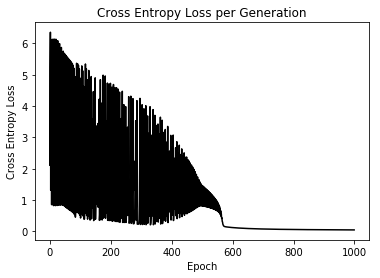

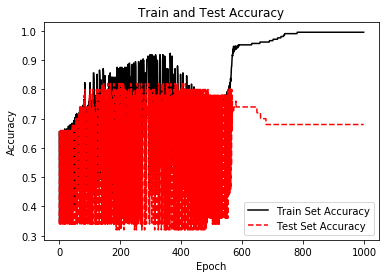

In [12]:
# Plot loss over time
plt.plot(costs, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [13]:
print (sess.run(accuracy, feed_dict={x: dataset, y: y_train_vector}))
print (sess.run(accuracy, feed_dict={x: test_dataset, y: y_test_vector}))

0.9952153
0.68


In [14]:
W.eval()

array([[ 0.01945245, -0.05326914, -0.02421807, ..., -0.02129809,
        -0.05439216,  0.04836478]], dtype=float32)

In [15]:
print (costs)

[2.1146035, 5.2438235, 6.3569407, 1.3149136, 6.0989566, 5.8261943, 0.8530735, 5.3769045, 6.134134, 1.1073103, 5.885537, 5.7904754, 0.8234742, 5.0544972, 6.1422153, 1.1158015, 5.6166286, 5.7771053, 0.8203281, 4.7011733, 6.135158, 1.1146924, 5.298739, 5.769759, 0.82611114, 4.3613815, 6.0856676, 1.0793025, 4.9432473, 5.7611685, 0.8318086, 4.0642715, 5.9936843, 1.0114837, 4.54362, 5.753773, 0.8368278, 3.835892, 5.87099, 0.924248, 4.088273, 5.7374206, 0.8331127, 3.6420186, 5.752137, 0.8454711, 3.6384087, 5.689949, 0.8061587, 3.4051006, 5.657134, 0.78627133, 3.2739089, 5.6160507, 0.76127064, 3.1215677, 5.577478, 0.73799175, 2.9828725, 5.5404544, 0.71584284, 2.8531065, 5.504912, 0.69478524, 2.7308583, 5.470165, 0.6744404, 2.612703, 5.4350276, 0.65418553, 2.4935393, 5.3976316, 0.6330944, 2.3657444, 5.354588, 0.6096022, 2.2156672, 5.2980957, 0.5804194, 2.0112855, 5.203368, 0.5366837, 1.6481142, 4.9403152, 0.45512372, 0.6876509, 2.6798525, 2.2754116, 5.36772, 0.60470414, 2.3522465, 5.3548784, 0.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


The Algo says [[1.]]
[[634.8475]]


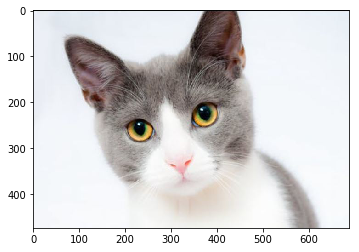

In [17]:
#Test Image 
fname = "cat1.JPG"  #LR is good
#fname = "cat3.JPG"  #LR is bad
#fname = "cat4.JPG"  #LR is good
#fname = "cartoon_grump.JPG"   #LR is bad
#fname = "puss.JPG"   #LR is bad
#fname = "meandog.JPG"  #LR is good
image = np.array(ndimage.imread(fname, flatten=False))
resized_image = scipy.misc.imresize(image, size=(64,64))
my_image = resized_image.reshape((1, 64*64*3)).T


print ("The Algo says " + str(A.eval({x:my_image})))
print (z.eval({x:my_image}))
plt.imshow(image)

#print (W)